# Assignment 1: Scalable Processing
## Yelp Reviews and Authenticity

Big Data Management | by ___ | ____@itu.dk | date

## Connecting to the Spark Cluster job using the two JobParameters.json

To connect this jupyter notebook with your Spark cluster, we need to tell jupyter how it can access the spark cluster. Below code accomplishes that. Do not worry about how it works, just run the cell once to connect. 

In [1]:
#####################################################################
# DO NOT CHANGE ANYTHING HERE.
# IF YOU HAVE PROBLEMS, CHECK THE ASSIGNMENT GUIDE CAREFULLY 
#####################################################################
from IPython.display import Javascript, display
import jupyterlab
import os, json, pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.conf import SparkConf
from py4j.protocol import Py4JJavaError


def show_popup(message):
    display(Javascript(f'alert("{message}")'))

def check_correct_file_location():
    items = os.listdir('/work')
    items_expected = ['yelp', 'Home','JobParameters.json', 'emails']
    if sorted(items) != sorted(items_expected):
        items_to_be_moved = [item for item in items if item not in items_expected and item[0] != '.'] # Ignore hidden files starting with .
        show_popup(f"Warning: Found these files {items_to_be_moved} that should (most likely) be moved inside your Home folder. Make sure your Git repository and notebooks are all saved inside your Home folder and not at the 'root'/top of filesystem. Please move your files to prevent them from disappearing.")
    if 'emails' not in items_expected:
        show_popup(f'Error: the folder "emails" does not seem to be accessible - did you remeber to add it to the Spark Cluster job and JupyterLab job?')
    
check_correct_file_location()

SUPPORTED_SPARK_VERSION = "3.3.1"
SUPPORTED_JUPYTERLAB_VERSION = "3.5.1"
if jupyterlab.__version__ != SUPPORTED_JUPYTERLAB_VERSION:
    show_popup(f"Wrong JupyterLab version :( When starting the UCloud job you selected {jupyterlab.__version__} but it should have been {SUPPORTED_JUPYTERLAB_VERSION}")
    show_popup("Please shutdown this JupyterLab job and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 
elif '_EXECUTED_' in globals(): # Only execute this cell once.
    # check if variable '_EXECUTED_' exists in the global variable namespace
    print("Already been executed once, not running again!")
else:
    print("Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.")
    # Two files are automatically read: JobParameters.json for the Spark Cluster job using a temporary spark instance
    # and JobParameters.json for the Jupyter Lab job to extract the hostname of the cluster. 

    MASTER_HOST_NAME = None

    # Open the parameters Jupyter Lab app was launched with
    with open('/work/JobParameters.json', 'r') as file:
        JUPYTER_LAB_JOB_PARAMS = json.load(file)
        # from pprint import pprint; pprint(JUPYTER_LAB_JOB_PARAMS) 
        for resource in JUPYTER_LAB_JOB_PARAMS['request']['resources']:
            if 'hostname' in resource.keys():
                MASTER_HOST_NAME = resource['hostname']

    if MASTER_HOST_NAME != "spark-cluster":
        msg = f"The JupyterLab job was started using spark hostname {MASTER_HOST_NAME}. This is not recommended, please start it using spark-cluster instead"
        show_popup(msg)
        print(msg)
    else:
        MASTER_HOST = f"spark://{MASTER_HOST_NAME}:7077"

        conf = SparkConf().setAll([
                ("spark.app.name", 'reading_job_params_app'), 
                ("spark.master", MASTER_HOST),
            ])

        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        
        if spark.version != SUPPORTED_SPARK_VERSION:
            show_popup(f"Wrong Spark Cluster version :( When starting the UCloud job you selected {spark.version} but it should have been {SUPPORTED_SPARK_VERSION}")
            show_popup("Please shutdown this JupyterLab job, the Spark Cluster and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 

        CLUSTER_PARAMETERS_JSON_DF = spark.read.option("multiline","true").json('/work/JobParameters.json')
        
        # Extract cluster info from the specific JobParameters.json
        NODES = CLUSTER_PARAMETERS_JSON_DF.select("request.replicas").first()[0]
        CPUS_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.cpu").first()[0] - 1
        MEM_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.memoryInGigs").first()[0]

        CLUSTER_CORES_MAX = CPUS_PER_NODE * NODES
        CLUSTER_MEMORY_MAX = MEM_PER_NODE * NODES 
        
        if CPUS_PER_NODE > 1:
            EXECUTOR_CORES = CPUS_PER_NODE - 1  # set cores per executor on worker node
        else:
            EXECUTOR_CORES = CPUS_PER_NODE 

        try:
            EXECUTOR_MEMORY = int(
                MEM_PER_NODE / (CPUS_PER_NODE / EXECUTOR_CORES) * 0.5
            )  # set executor memory in GB on each worker node
        except ZeroDivisionError:
            show_popup(f"Please make sure you selected 3 nodes for the Spark Cluster, each with 24 GB of ram. You selected {MEM_PER_NODE} GB ram and {NODES} node(s)")
            
        # Make sure there is a dir for spark logs
        if not os.path.exists('spark_logs'):
            os.mkdir('spark_logs')

        conf = SparkConf().setAll(
            [
                ("spark.app.name", 'spark_assignment'), # Change to your liking 
                ("spark.sql.caseSensitive", False), # Optional: Make queries strings sensitive to captialization
                ("spark.master", MASTER_HOST),
                ("spark.cores.max", CLUSTER_CORES_MAX),
                ("spark.executor.cores", EXECUTOR_CORES),
                ("spark.executor.memory", str(EXECUTOR_MEMORY) + "g"),
                ("spark.eventLog.enabled", True),
                ("spark.eventLog.dir", "spark_logs"),
                ("spark.history.fs.logDirectory", "spark_logs"),
                ("spark.deploy.mode", "cluster"),
            ]
        )

        ## check executor memory, taking into accout 10% of memory overhead (minimum 384 MiB)
        CHECK = (CLUSTER_CORES_MAX / EXECUTOR_CORES) * (
            EXECUTOR_MEMORY + max(EXECUTOR_MEMORY * 0.10, 0.403)
        )

        assert (
            int(CHECK) <= CLUSTER_MEMORY_MAX
        ), "Executor memory larger than cluster total memory!"

        # Stop previous session that was just for loading cluster params
        spark.stop()

        # Start new session with above config, that has better resource handling
        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        sc = spark.sparkContext
        _EXECUTED_ = True
        print("Success!")

<IPython.core.display.Javascript object>

Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.
Success!


Click on the "SparkMonitor" tab at the top in Jupyter Lab to see the status of running code on the cluster.

In [45]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data
Here we specify where the yelp datasets are located on UCloud and read then using the spark session.

In [2]:
# Read in the business and review files
# This is the path to the shared datasets provided by adding an the dataset input folder
# when submitting the spark cluster job.
business = spark.read.json('file:////work/yelp/yelp_academic_dataset_business.json') # Use the file:/// prefix to indicate we want to read from the cluster's filesystem
business = business.persist()
# Persist 2 commonly used dataframes since they're used for later computations
# https://sparkbyexamples.com/spark/spark-difference-between-cache-and-persist/

users = spark.read.json("file:////work/yelp/yelp_academic_dataset_user.json")

reviews = spark.read.json('file:////work/yelp/yelp_academic_dataset_review.json')
reviews = reviews.persist()

## PySpark example usage

In [3]:
# Show PySpark dataframes:
reviews.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [4]:
business.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

In [35]:
business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [5]:
# Get number of rows with no sampling:
reviews.count()

6990280

In [6]:
reviews.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [8]:
buss_review = reviews.join(business, on = "business_id", how='inner')
buss_review.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+-----+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|         address|          attributes|          categories|           city|               hours|is_open|  latitude|  longitude|             name|postal_code|review_count|stars|state|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+--------------------+--------------------+---------------+--------------------+-------+----------+-----------+-----------------+-----------+------------+-----+-----+
|---kPU91CF4Lq2-Wl...|   1|2021-03-06 01:39:34|    0|ROpgxHN-NOZ

In [10]:
buss_review.limit(3).toPandas()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,address,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,---kPU91CF4Lq2-WlRu9Lw,0,2021-11-25 02:49:38,0,2HVxhnbaUfSfmC_RHjXLaQ,5.0,"Hidden gem in NPR. Ordered the stone crabs, cr...",0,lEPRGtvLLfJ2BQcU_w5UuA,4903 State Rd 54,...,New Port Richey,"(11:0-22:0, 0:0-0:0, 11:0-22:0, None, 11:0-21:...",1,28.217288,-82.733344,Frankie's Raw Bar,34652,24,4.5,FL
1,---kPU91CF4Lq2-WlRu9Lw,0,2020-08-09 19:19:16,0,hoLKem4XpXGt_X4liqW9lw,4.0,Ate here for the 1st time on Saturday 08/07/20...,0,415SXXbQrl2-VudHa3ImbQ,4903 State Rd 54,...,New Port Richey,"(11:0-22:0, 0:0-0:0, 11:0-22:0, None, 11:0-21:...",1,28.217288,-82.733344,Frankie's Raw Bar,34652,24,4.5,FL
2,---kPU91CF4Lq2-WlRu9Lw,0,2020-09-05 20:09:03,0,gzXaxjjTnrJJuG_gqvnmuw,5.0,Absolutely fantastic!!!! I'll be back for sur...,0,ey8tdgUgC2tFqw2dfrr0QQ,4903 State Rd 54,...,New Port Richey,"(11:0-22:0, 0:0-0:0, 11:0-22:0, None, 11:0-21:...",1,28.217288,-82.733344,Frankie's Raw Bar,34652,24,4.5,FL


In [16]:
buss_review.groupby(['business_id', 'name']) \
            .count() \
            .show(10)

+--------------------+--------------------+-----+
|         business_id|                name|count|
+--------------------+--------------------+-----+
|kV_Q1oqis8Qli8dUo...|       Ardmore Pizza|  114|
|Reu96YB9weBlJ3vxr...|Silver Sage Cente...|   25|
|DVbsnj9WH8Qd5exQZ...|       Papa Murphy's|   32|
|NcO-pWiZmNM5zBg8H...|La Tavola Ristora...|  200|
|apgDJMu1GS4vXpNmy...|A 7th Heaven Hair...|   21|
|a1E2BPYnufFzb6YX2...|  Wahoo's Fish Tacos|   62|
|Ql466RUZPLvKo_Cc9...|New Kimono Sushi ...|   29|
|GlYN-RJyL_YwxIqsS...|Mother Hubbard's ...|  263|
|6kPHr6gZaU9732ptn...|La Guerrerita Mex...|  132|
|qq4Zc5y76vfCxQQy4...|    The Casino Grill|   38|
+--------------------+--------------------+-----+
only showing top 10 rows



In [37]:
null_counts = business.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in business.columns
])
null_counts.show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     13744|          0|       103|   0|23223|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



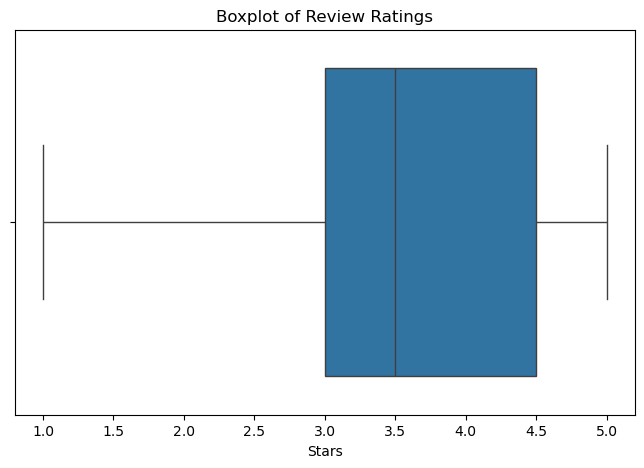

In [46]:
reviews_pd = business.select("stars").dropna().toPandas()

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x=reviews_pd["stars"])
plt.title("Boxplot of Review Ratings")
plt.xlabel("Stars")
plt.show()

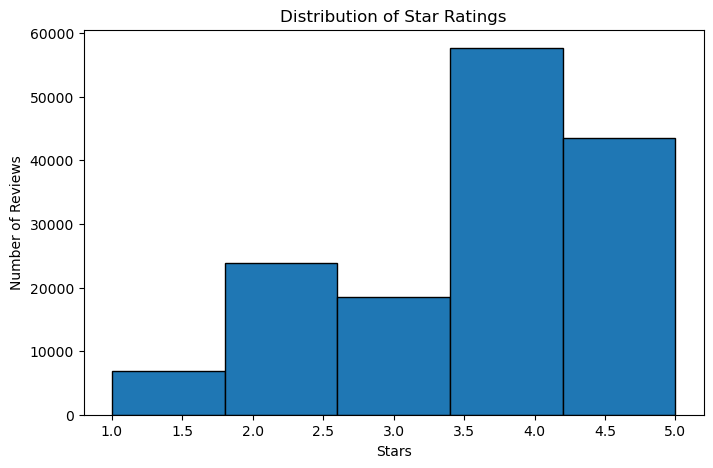

In [47]:
reviews_pd = business.select("stars").dropna().toPandas()

plt.figure(figsize=(8,5))
plt.hist(reviews_pd["stars"], bins=5, edgecolor="k")  # 1 bin per star
plt.title("Distribution of Star Ratings")
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.show()

In [33]:
star5 = (
    business.groupby('business_id', 'name') \
                .agg(
                    F.avg("stars").alias("avg_stars"),
                    F.count("*").alias("count")
                                      )
                .filter((F.col("avg_stars") == 5) & (F.col("count") >= 500))
    )
    

In [30]:
star5 = (
    business.groupBy("business_id", "name")
            .agg(
                F.avg("stars").alias("avg_stars"),
                F.count("*").alias("review_count")
            )
            .filter((F.col("avg_stars") == 5) & (F.col("review_count") >= 500))
)

In [34]:
star5.show()

+-----------+----+---------+-----+
|business_id|name|avg_stars|count|
+-----------+----+---------+-----+
+-----------+----+---------+-----+



In [ ]:
# OPTIONAL:
# Reduce resource usage and make queries run faster
# by only using a small sample of the dataframe
# and overwriting previous variable "df".
# Useful while developing, not so much to
# provide final answers. Therefore: Remember to 
# to re-read the df when done developing code using
# df = spark.read etc like above.
reviews = reviews.sample(withReplacement=False, fraction=1/50)

# Get number of rows after sampling:
reviews.count() 

In [ ]:
business.show()

Example: Say we're only interested in reviews of good mexican restaurants in Arizona. You can delete this when you do your own thing. 

In [6]:
reviews.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [ ]:
# Filter to only Arizona businesses with "Mexican" as part of their categories
az_mex = business.filter(business.state == "AZ")\
                .filter(business.categories.rlike("Mexican"))\
                .select("business_id", "name")

# Join with the reviews
az_mex_rs = reviews.join(az_mex, on="business_id", how="inner")

# Filter to only 5 star reviews
good_az_mex_rs = az_mex_rs.filter(az_mex_rs.stars == 5)\
                        .select("name","text")

# Print the top 20 rows of the DataFrame
good_az_mex_rs.show()

# Convert to pandas (local object) and save to local file system
good_az_mex_rs.toPandas().to_csv("good_az_reviews.csv", header=True, index=False, encoding='utf-8')


See assignment PDF for task descriptions.

### Task 3.1.1:

In [ ]:
# Write your code here...

### Task 3.1.2:

In [ ]:
# Write your code here...

### Task 3.1.3: 

In [ ]:
# Write your code here...

### Task 3.1.4: 

In [ ]:
# Write your code here...

### Task 3.1.5: 

In [ ]:
# Write your code here...

### Task 3.2.1: Data Exploration

In [ ]:
# Write your code here...

### Task 3.2.2: Hypothesis Testing

In [ ]:
# Write your code here...

### Task 3.3: Building a Rating Prediction Model

In [ ]:
# Write your code here...